In [1]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import sys

for mod in ["sutton_functions"]:
    if mod in sys.modules:
            del sys.modules[mod]
            
from sutton_functions import *

CPU times: user 613 ms, sys: 2.01 s, total: 2.62 s
Wall time: 328 ms


In [2]:

# # Example usage
temperature_C = 20 # Temperature in Celsius
temperature_K = temperature_C + 273.15  # Convert to Kelvin

es = saturation_vapor_pressure(temperature_K)
rho = vapor_concentration(es, temperature_K)

print(f"Saturation vapor pressure at {temperature_C}°C is {es:.2f} Pa")
print(f"Water vapor concentration at {temperature_C}°C is {rho:.2f} g/m³")


Saturation vapor pressure at 20°C is 2366.09 Pa
Water vapor concentration at 20°C is 17.49 g/m³


In [3]:
def define_params(k = 0.4, g = 9.8, ustar = 0.2, zom = 0.1/100, 
                  Lx = 1000, Hmax = 50, dx = 0.5, dz = 0.1, 
                  Ta_u = 18, Ts_u = 32, Ts_d = 24, Qa = 25):

    # zoh = zom*7.4*np.exp(-7.3*0.4*(ustar*zom/1.5e-5)**0.25)  
    zoh = zom
    xmin = 0
    xmax = Lx
    zmin = zom
    zmax = Hmax

    # Generate grid
    nx = int(Lx/dx)
    nz = int(Hmax/dz)
    
    x = np.arange(xmin, xmax + dx, dx)
    z = np.arange(zmin + dz, zmax + dz, dz)

    zc = z.copy()
    zc[0] = dz / np.log(z[1]/z[0])
    for i in range(1, nz-1):
        zc[i] = dz*2/ np.log(z[i+1]/z[i-1])
    zc[-1] = dz / np.log(z[-1]/z[-2])

    # Generate the mean velocity from log-law
    U_up = (ustar / k) * np.log(z / zom)

    # Specify upwind temperature (as background)
    # Downwind air temperature = upwind air temp
    Ta_d = Ta_u
       
    es = saturation_vapor_pressure(Ts_u + 273.15)
    rho = vapor_concentration(es, Ts_u + 273.15)

    # Water vapor boundary conditions (gm/m3)
    Qs = rho      # Surface wv concentration
    Qa = Qa       # Upwind background atmospheric wv concentration
    
    # Combine all into a dictionary
    template = {
        "k": k, # von Karman constant
        "g": g,  # gravity
        "ustar": ustar, # Friction velocity (m/s)
        "zom": zom, # Momentum roughness length (m) 
        "zoh": zoh, # Heat roughness length (m) 
        "Lx": Lx,
        "Hmax": Hmax,
        "xmin": xmin,
        "xmax": xmax,
        "zmin": zmin,
        "zmax": zmax,
        "nx": nx,
        "nz": nz,
        "dx": dx,
        "dz": dz,
        "z": z,
        "zc" : zc,
        "x": x,
        "U_up": U_up,
        "Ta_u": Ta_u,
        "Ts_u": Ts_u,
        "Ts_d": Ts_d,
        "Ta_d": Ta_d,
        "es": es,
        "rho": rho,
        "Qs" : Qs,
        "Qa" : Qa}
    return template

params = define_params()


In [4]:
# ax = plt.gca()
# xi = np.arange(-5, 5, .1)
# phi = stability(xi)
# plt.plot(- xi, phi, '.-')
# ax.set_ylim(0, 5)
# ax.axhline(1, c = 'grey')

In [14]:
def integrate_H2O_implicit(params, A, B, C, Q_up, Qs, Qa):
    """
    This function computes the coefficients
      of the second-order system of variable s(t+dt)
      formed by the (known) profile values at s(t).
      
      The system is AA1 d2s/dz2 + AA2 ds/dz + AA3 s=AA4
      The coefficients in AA4 are used from s(t)
      The coefficients in AA1 are mainly the diffusion
      The coefficients in AA2 include advection
      The coefficients in AA3 include advection + s(t+dt)  
    """
    # Setup the tridiagonal solver for mean H2O concentration
    n = params['nx']
    m = params['nz']
    dx = params['dx']
    dz = params['dz']
    z = params['z']
    zc = params['zc']    
    
    ustar = params['ustar']
    k = params["k"]
    g = params["g"]
    ustar = params["ustar"]
    
    # Setup the tridiagonal solver for mean H2O concentration    
    AA1 = - A * B
    AA2 = - C * B
    AA3 = 1 / dx
    AA4 = Q_up / dx
    
    upd = (AA1 / (dz ** 2) + AA2 / (2 * dz))
    dia = (-2 * AA1 / (dz ** 2) + AA3)
    lod = (AA1 / (dz ** 2) - AA2 / (2 * dz))
    
    co = np.zeros(m)
    co[:] = AA4

    # Ensure the boundary conditions are state, not flux
    lod[0] = 0
    lod[m-1] = 0
    dia[0] = 1
    dia[m-1] = 1
    upd[0] = 0
    upd[m-1] = 0

    # Enforce surface and upper H2O concentration
    co[0] = Qs
    co[m-1] = Qa

    # Call the tridiagonal solver
    Q1 = thomas(lod, dia, upd, co)
    dQdz = our_central_difference(Q1, dz)
    
    Fq = np.zeros_like(Q1)    
    Fq[1:] = - 0.5 * (A[1:] + A[:-1]) * (0*dQdz[:-1] + dQdz[1:]) * 0.5

    Fq[1] = Fq[2]
    Fq[0] = Fq[1]  
    # Fq = - A*zc/z * dQdz
    
    return Q1, Fq

def integrate_T_implicit(params, A, B, C, T_up, Ts, Ta):
    """
    This function computes the coefficients
      of the second-order system of variable s(t+dt)
      formed by the (known) profile values at s(t).
      
      The system is AA1 d2s/dz2 + AA2 ds/dz + AA3 s=AA4
      The coefficients in AA4 are used from s(t)
      The coefficients in AA1 are mainly the diffusion
      The coefficients in AA2 include advection
      The coefficients in AA3 include advection + s(t+dt)  
    """   
    n = params['nx']
    m = params['nz']
    dx = params['dx']
    dz = params['dz']
    z = params['z']
    zc = params['zc']    
    
    ustar = params['ustar']
    k = params["k"]
    g = params["g"]
    ustar = params["ustar"]
  
    # Setup the tridiagonal solver for mean H2O concentration
    AA1 = - A * B
    AA2 = - C * B
    AA3 = 1 / dx
    AA4 = T_up / dx
    
    upd = (AA1 / (dz ** 2) + AA2 / (2 * dz))
    dia = (-2 * AA1 / (dz ** 2) + AA3)
    lod = (AA1 / (dz ** 2) - AA2 / (2 * dz))
    
    co = np.zeros(m)
    co[:] = AA4

    # Ensure the boundary conditions are state, not flux
    lod[0] = 0
    lod[m-1] = 0
    dia[0] = 1
    dia[m-1] = 1
    upd[0] = 0
    upd[m-1] = 0

    # Enforce surface and upper H2O concentration
    co[0] = Ts
    co[m-1] = Ta

    # Call the tridiagonal solver
    T1 = thomas(lod, dia, upd, co)
    dTdz = our_central_difference(T1, dz)
    
    FT = np.zeros_like(T1)
    FT[1:] = - 0.5 * (A[1:] + A[:-1]) * (0*dTdz[:-1] + dTdz[1:]) * 0.5
    
    FT[1] = FT[2]
    FT[0] = FT[1]    
    # FT = - A*zc/z * dTdz
    
 
    return T1, FT

def padit(x,  nz, upwind, array):
    """
    """
    xx = np.concatenate([np.arange(-120, 0), x])

    up = upwind.reshape(1, nz)
    up = np.concatenate([up, up, up, up, up, up, up, up, up, up, up, up, up, up, up, up, up, up, up, up])
    array = np.concatenate([up, up, up, up, up, up, array])

    return xx, array


### Upwind temperature profile
Ensure that  $\partial T/\partial x = 0$, so

$$U \frac{\partial T}{\partial x} = - \frac{\partial }{\partial z}\overline{w'T'} =  \frac{\partial }{\partial z}\bigg( K_t(z) \frac{\partial T}{\partial z} \bigg) = 0$$


$$ K_t(z)  \frac{\partial^2 T}{\partial z^2} + \frac{\partial K_t (z)}{\partial z}  \frac{\partial T}{\partial z} = 0$$



$$ A \frac{\partial^2 T}{\partial z^2} + B \frac{\partial T}{\partial z} = 0$$



In [15]:
def iterate_stability(T_up, params):
    
    k = params["k"]
    z = params["z"]
    dx = params["dx"]
    dz = params["dz"]
    zc = params["zc"]    
    
    ustar = params["ustar"]    
    g = params["g"]
    nx = params["nx"]
    nz = params["nz"]
    Ts_d = params['Ts_d']
    U_up = params['U_up']
    
    # Setup coefficients for implicit scheme
    A1 = k * z * ustar
    B1 = our_central_difference(A1, dz)  

    # upwind temperature gradient
    dTdz_up = our_central_difference(T_up, dz)

    upd = A1/dz**2 + B1/2/dz
    dia = -2*A1/dz**2 
    lod = A1/dz**2 - B1/2/dz

    # Ensure the boundary conditions are state, not flux
    lod[0] = 0
    lod[nz-1] = 0
    dia[0] = 1
    dia[nz-1] = 1
    upd[0] = 0
    upd[nz-1] = 0

    co = np.zeros(nz)
    co[0] = T_up[0]
    co[-1] = T_up[-1]

    T1 = thomas(lod, dia, upd, co)
    dTdz = our_central_difference(T1, dz)
    FT1 = - A1 *zc/z* dTdz

    for i in range(10):

        FT0 = FT1.copy()

        # compute stability
        # approximate Ta = 273.15+Ts_d
        Lo = - ustar**3/(k*g*FT1/(273.15+Ts_d))
        xi = z/Lo
        phi = stability(xi)

        # second iteration: setup coefficients for implicit scheme
        A1 = k * z * ustar/phi[1]
        B1 = our_central_difference(A1, dz)  

        upd = A1/dz**2 + B1/2/dz
        dia = -2*A1/dz**2 
        lod = A1/dz**2 - B1/2/dz

        # Ensure the boundary conditions are state, not flux
        lod[0] = 0
        lod[nz-1] = 0
        dia[0] = 1
        dia[nz-1] = 1
        upd[0] = 0
        upd[nz-1] = 0

        co = np.zeros(nz)
        co[0] = T_up[0]
        co[-1] = T_up[-1]

        T1 = thomas(lod, dia, upd, co)
        dTdz = our_central_difference(T1, dz)
        
        FT = np.zeros_like(T1)    
        
        FT[1:] = - 0.5 * (A1[1:] + A1[:-1]) * (0*dTdz[:-1] + dTdz[1:]) * 0.5
        
        FT[1] = FT[2]
        FT[0] = FT[1]    
    

        #FT1 = - A1*zc/z * dTdz
        
        error = (FT - FT0).sum()

    return T1, dTdz, FT, error

In [16]:
def wrap_T( params, stable = True ):
    
    import copy
    
    params = copy.deepcopy(params)
    nx = params["nx"]
    nz = params["nz"]
    dx = params["dx"]
    dz = params["dz"]
    z = params["z"]
    zc = params["zc"]
    
    k = params["k"]
    g = params["g"]
    ustar = params["ustar"]
    U_up = params['U_up']

    Ts_d = params["Ts_d"]
    Ta_d = params["Ta_d"]
    
    Ta_u = params["Ta_u"]    
    Ts_u = params["Ts_u"]    
    
    zmax = params['z'].max()
    zoh = params['zoh']    

    Qa = params["Qa"]
    Qs = params["Qs"]        
    
    # initial guess: upwind temperature conditions
    wT = - (Ta_u - Ts_u)*k*ustar/np.log(zmax/zoh)
    T_up = Ts_u - wT/(k*ustar)*np.log(z/zoh)

    # iterate upwind temperature conditions    
    T = np.zeros((nx + 1, nz))
    FluxT = np.zeros((nx + 1, nz))
    
    if stable == True:
        T1, dTdz, FT1, error= iterate_stability(T_up, params)
    else:
        T1 = T_up
        A1 = k * z * ustar
        dTdz = our_central_difference(T1, dz)
        FT1 = - A1*zc/z * dTdz
        
    T[0] = T1 
    FluxT[0] = FT1
    params['T_up'] = T1
    
    Q = np.zeros((nx + 1, nz))
    FluxQ = np.zeros((nx + 1, nz))    
    phis = np.ones(nx+1)
    xis = np.zeros(nx+1)

    # Specify upwind wv concentration (as background)
    Q_up = np.ones(nz) * Qa    
    Q1 = Q_up  
    dQdz = our_central_difference(Q1, dz)
    FQ = - k * z * ustar * dQdz
    
    Q[0, :] = Q1
    FluxQ[0, :]   = FQ    
    
    for i in range(nx):

        Lo = - ustar**3/(k*g*FT1/(273.15+Ts_d))
        xi = z/Lo
        # save stability parameter xi at surface
        xis[i+1] = xi[0]
        
        # update stability
        if stable == True:
            # use stability at the surface
            phi = stability(xi)[0]  
        else:
            phi = 1
            
        # Setup coefficients for implicit scheme
        A = k * z * ustar/phi
        B = 1.0/ U_up
        C = our_central_difference(A, dz)
        T2, FT2 = integrate_T_implicit(params, A, B, C, T1, Ts_d, Ta_d)

        T1 = T2.copy()
        FT1 = FT2.copy()

        FluxT[i+1]  = FT2
        T[i+1]  = T2
        
        Q2, Fq = integrate_H2O_implicit(params, A, B, C, Q1, Qs, Qa)
        Q1 = Q2.copy()  
        
        Q[i+1, :] = Q2
        FluxQ[i + 1, :] = Fq    
        phis[i + 1] = phi
        
    params['T'] = T.round(5)
    params['Q'] = Q.round(5)
    params['FluxT'] = FluxT.round(5)
    params['FluxQ'] = FluxQ.round(5)
    params['phi'] = phis
    params['xi'] = xis
    
    
    return params


def update_T( params):
    
    import copy
    
    params = copy.deepcopy(params)
    nx = params["nx"]
    nz = params["nz"]
    dx = params["dx"]
    dz = params["dz"]
    z = params["z"]
    zc = params["zc"]
    
    k = params["k"]
    g = params["g"]
    ustar = params["ustar"]
    U_up = params['U_up']

    Ts_d = params["Ts_d"]
    Ta_d = params["Ta_d"]
    
    Ta_u = params["Ta_u"]    
    Ts_u = params["Ts_u"]    
    
    zmax = params['z'].max()
    zoh = params['zoh']    

    Qa = params["Qa"]
    Qs = params["Qs"]        
    

    # iterate upwind temperature conditions    
    T = params['T']
    FluxT = params['FluxT']
        
    T1 = params['T_up']
    FT1 = params['FluxT'][0, :]    

    Q = params['Q']
    FluxQ = params['FluxQ'] 
    phis = params['phi'] 
    xis = params['xi'] 

    # Specify upwind wv concentration (as background)
    Q1 = params['Q'][0, :]
    dQdz = our_central_difference(Q1, dz)
    FQ = - k * z * ustar * dQdz
    
    
    for i in range(nx):
        
        FT1 = FluxT[i+1] + 1e-16
        Lo = - ustar**3/(k*g*FT1/(273.15+Ts_d))
        xi = z/Lo
        # save stability parameter xi at surface
        xis[i+1] = xi[0]
        
        phi = stability(xi)[0]  

        # Setup coefficients for implicit scheme
        A = k * z * ustar/phi
        B = 1.0/ U_up
        C = our_central_difference(A, dz)
        T2, FT2 = integrate_T_implicit(params, A, B, C, T1, Ts_d, Ta_d)

        T1 = T2.copy()
        FT1 = FT2.copy()

        FluxT[i+1]  = FT2
        T[i+1]  = T2
        
        Q2, Fq = integrate_H2O_implicit(params, A, B, C, Q1, Qs, Qa)
        Q1 = Q2.copy()  
        
        Q[i+1, :] = Q2
        FluxQ[i + 1, :] = Fq    
        phis[i + 1] = phi
        
    params['T'] = T.round(5)
    params['Q'] = Q.round(5)
    params['FluxT'] = FluxT.round(5)
    params['FluxQ'] = FluxQ.round(5)
    params['phi'] = phis
    params['xi'] = xis
    
    
    return params



In [17]:
w_stability = wrap_T(params, stable = True )
no_stability = wrap_T(params, stable = False)



In [18]:
# import copy
# iterations= []
# iteration = copy.deepcopy(w_stability)
# for i in range(10):
#     iteration = update_T(iteration)
#     iterations.append(iteration)
#     print (np.sum(iterations[-1]['T'] - w_stability['T']))
#     plt.plot(i, np.sum(iterations[-1]['T'] - w_stability['T']), 'ro')

(0.0, 0.105919)

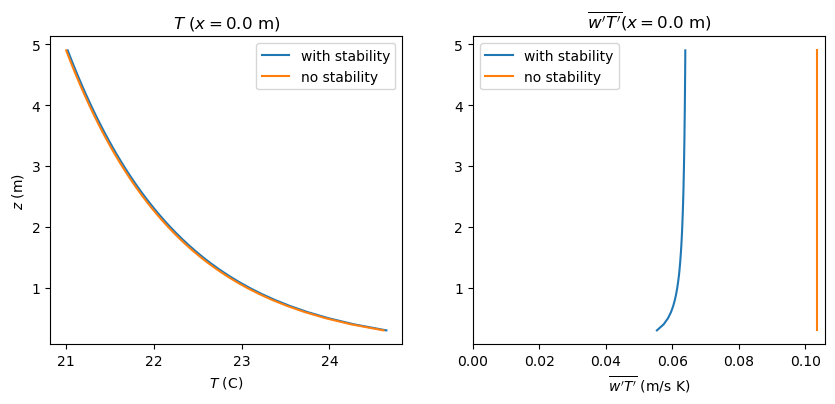

In [21]:
zind = np.where(params['z'] >= 5)[0][0]
xind = 0

fig, axes = plt.subplots(1,2, figsize = (10,4))
ax = axes[0]
ax.plot(w_stability['T'][xind][2:zind], params['z'][2:zind], label = 'with stability')
ax.plot(no_stability['T'][xind][2:zind], params['z'][2:zind], label = 'no stability')
ax.legend()
ax.set_title("$T$ ($x = {0}$ m)".format(params['x'][xind]))
ax.set_xlabel("$T$ (C)")
ax.set_ylabel("$z$ (m)")


ax = axes[1]
ax.plot(w_stability['FluxT'][xind][2:zind], params['z'][2:zind], label = 'with stability')
ax.plot(no_stability['FluxT'][xind][2:zind], params['z'][2:zind], label = 'no stability')
ax.legend()
ax.set_title(r"$\overline{w'T'}$" +"($x = {0}$ m)".format(params['x'][xind]))
ax.set_xlabel("$\overline{w'T'}$ (m/s K)")
ax.set_xlim(0,)


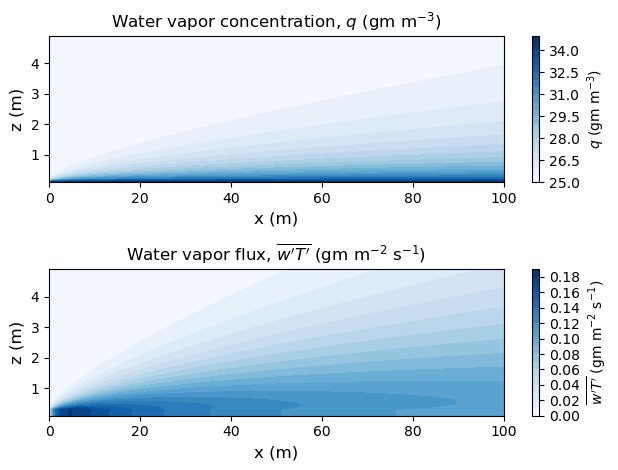

In [22]:
# Plot water vapor concentration and vertical flux
plt.figure()

zind = np.where(params['z'] > 5)[0][0]
xind = np.where(params['x'] > 100)[0][0]
plt.subplot(2, 1, 1)
plt.contourf(params['x'][:xind], params['z'][:zind], (w_stability['Q'].round(5)[:xind, :zind].T), 21, 
             cmap="Blues",  vmin = params['Qa'], vmax = params['Qs'])
plt.colorbar(label="$q$ (gm m$^{-3}$)")
plt.xlabel("x (m)", fontsize=12, fontweight="normal")
plt.ylabel("z (m)", fontsize=12, fontweight="normal")
plt.title("Water vapor concentration, $q$ (gm m$^{-3}$)", fontsize=12)

plt.subplot(2, 1, 2)
plt.contourf(params['x'][:xind], params['z'][:zind], w_stability['FluxQ'][:xind, :zind].T, 21, 
             cmap="Blues")
plt.colorbar(label="$\overline{w'T'}$ (gm m$^{-2}$ s$^{-1}$)")
plt.xlabel("x (m)", fontsize=12, fontweight="normal")
plt.ylabel("z (m)", fontsize=12, fontweight="normal")
plt.title("Water vapor flux, $\overline{w'T'}$ (gm m$^{-2}$ s$^{-1}$)", fontsize=12)

plt.tight_layout()
plt.show()

Text(0.5, 0, '$q$ (gm/m$^3$)')

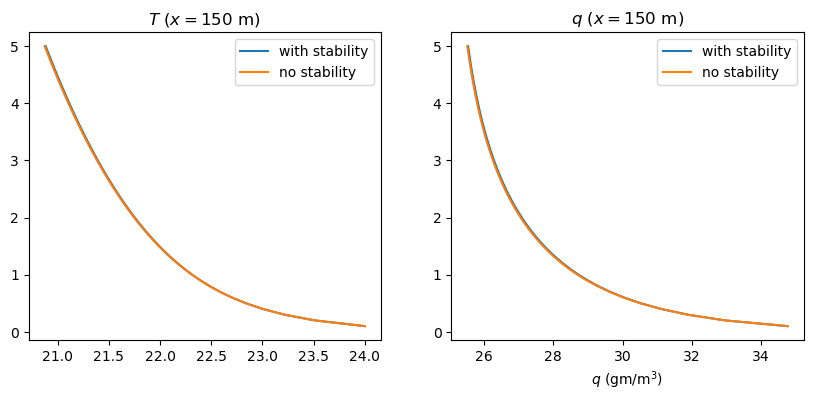

In [23]:
zind = 50
xind = 300

fig, axes = plt.subplots(1,2, figsize = (10,4))
ax = axes[0]
ax.plot(w_stability['T'][xind][:zind], params['z'][:zind], label = 'with stability')
ax.plot(no_stability['T'][xind][:zind], params['z'][:zind], label = 'no stability')
ax.legend()
ax.set_title("$T$ ($x = {0:.0f}$ m)".format(params['x'][xind]))

ax = axes[1]
ax.plot(w_stability['Q'][xind][:zind], params['z'][:zind], label = 'with stability')
ax.plot(no_stability['Q'][xind][:zind], params['z'][:zind], label = 'no stability')
ax.legend()
ax.set_title("$q$ ($x = {0:.0f}$ m)".format(params['x'][xind]))
ax.set_xlabel("$q$ (gm/m$^3$)")


In [24]:
reds = ['#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#b30000','#7f0000']
blues = ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#253494','#081d58']

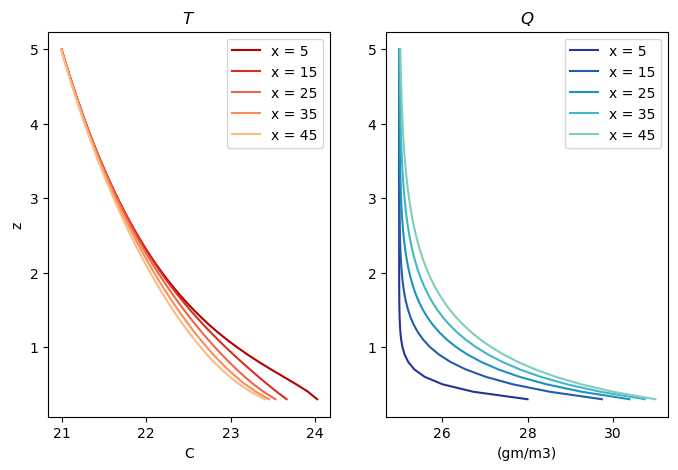

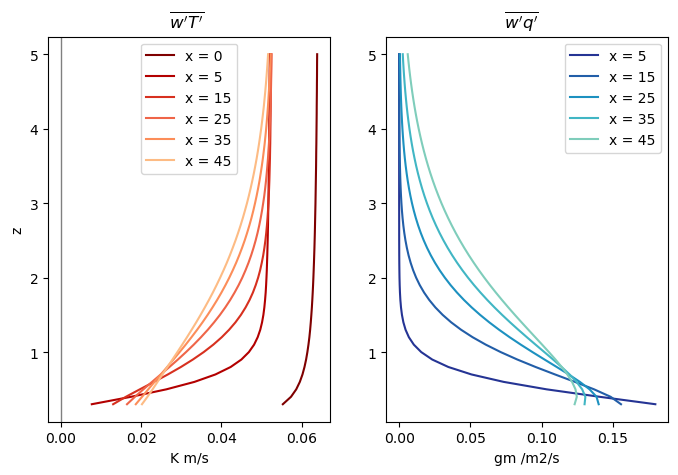

In [28]:
zind = 50
xinds = np.arange(10, 100, 20)
z = params['z']
x = params['x']

fig, axes = plt.subplots(1,2, figsize = (8, 5))
ax = axes[0]
for ind, i in enumerate(xinds):
    ax.plot( w_stability['T'][i][2:zind], z[2:zind], label = "x = {0:.0f}".format(params['x'][i]), c = reds[-ind-2])
ax.legend()
ax.set_xlabel("C")
ax.set_ylabel("z")
ax.set_title("$T$")
ax = axes[1]

# ax.plot( Q[0], z, c = blues[-1], label = 'x = 0')
for ind, i in enumerate(xinds):
    ax.plot( w_stability['Q'][i][2:zind], z[2:zind], label = "x = {0:.0f}".format(x[i]), c = blues[-ind-2])   
ax.legend()
ax.set_xlabel("(gm/m3)")
ax.set_title("$Q$ ")
# ax.set_xlim(Ta_u, Ta_u+5)


fig, axes = plt.subplots(1,2, figsize = (8, 5))
ax = axes[0]
ax.plot( w_stability['FluxT'][0][2:zind], z[2:zind], c = reds[-1], label = 'x = 0')
for ind, i in enumerate(xinds):
    ax.plot( w_stability['FluxT'][i][2:zind], z[2:zind], label = "x = {0:.0f}".format(x[i]), c = reds[-ind-2])
ax.legend()
ax.axvline(0, c = 'grey', lw = 1)
ax.set_xlabel("K m/s")
ax.set_ylabel("z")
ax.set_title("$\overline{w'T'} \ $ ")

ax = axes[1]
for ind, i in enumerate(xinds):
    ax.plot( w_stability['FluxQ'][i][2:zind], z[2:zind], label = "x = {0:.0f}".format(x[i]), c = blues[-ind-2])
ax.legend()
ax.set_xlabel("gm /m2/s")
ax.set_title("$\overline{w'q'} \ $  ");

Text(0.5, 1, 'No stability')

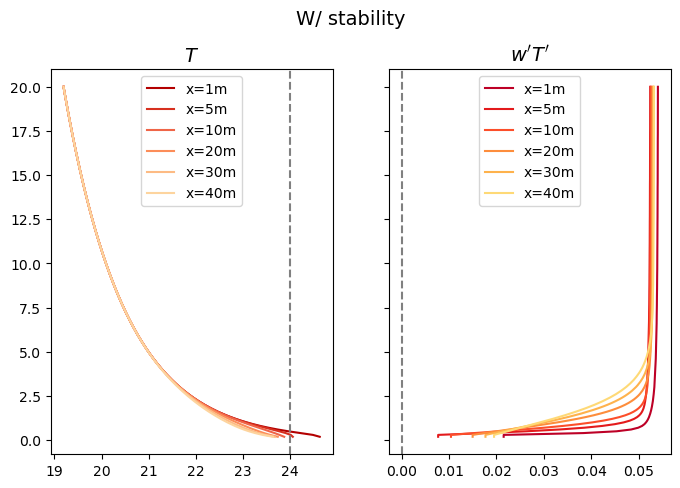

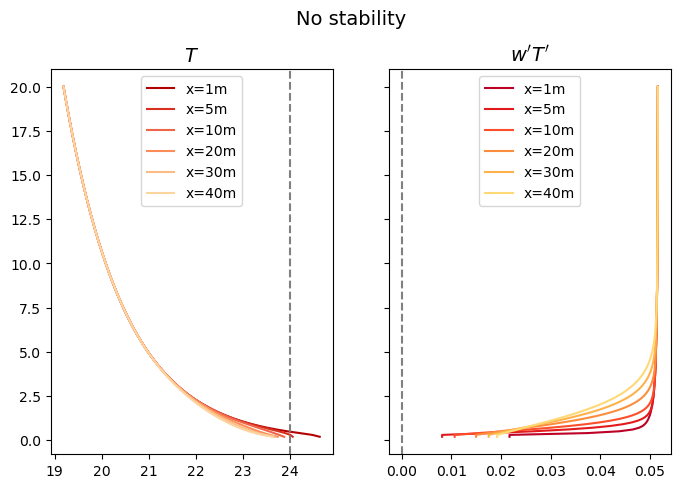

In [29]:
reds2 = ['#ffffcc','#ffeda0','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#bd0026','#800026']

reds = ['#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#b30000','#7f0000']


def plot_profile(params, variable, title, ax, z_ind = 100, cmap = reds):

    array = params[variable]
    z = params['zc']
    dx = params['dx']
    x = params['x']    
    #ax.plot(array[0, 1:z_ind], z[1:z_ind], c = reds[-1], label  = 'x=0')
    for ind, i in enumerate([int(1/dx), int(5/dx), int(10/dx), int(20/dx), int(30/dx),  int(40/dx)]):
        ax.plot(array[i,1:z_ind], z[1:z_ind], c = cmap[-ind-2], label = "x={0:.0f}m".format(x[i]))
    ax.legend()
    ax.set_title(title, fontsize = 14)

z_ind = 200
fig, axes = plt.subplots(1,2, figsize= (8, 5), sharey = True)
plot_profile(w_stability, 'T', "$T$", axes[0], z_ind = z_ind, cmap = reds)  
plot_profile(w_stability, 'FluxT', "$w'T'$", axes[1], z_ind = z_ind, cmap = reds2)  
axes[1].axvline(0, c = 'grey', ls = '--')
axes[0].axvline(no_stability['Ts_d'], c = 'grey', ls = '--')
plt.suptitle("W/ stability", y = 1, fontsize = 14)

fig, axes = plt.subplots(1,2, figsize= (8, 5), sharey = True)
plot_profile(no_stability, 'T', "$T$", axes[0], z_ind = z_ind, cmap = reds)  
plot_profile(no_stability, 'FluxT', "$w'T'$", axes[1], z_ind = z_ind, cmap = reds2)  
axes[1].axvline(0, c = 'grey', ls = '--')
axes[0].axvline(no_stability['Ts_d'], c = 'grey', ls = '--')
plt.suptitle("No stability", y = 1, fontsize = 14)

In [30]:
# FluxT, T = wrap_T(params, local_stability = False)
# FluxT_local, T_local = wrap_T(params, local_stability = True)

## Temperature plots

In [35]:
def plot_colormap(params, variable, title, ax, vmin = None, vmax = None, cmap = 'coolwarm'):
    x = params['x']
    z = params['z']
    nz = params['nz']    
    array = params[variable]

    xx = x   
    # xx, array = padit(x, nz, array[0], array)
    
    if vmin == 'center' or vmax == 'center':
        max_abs_value = np.percentile(np.abs(array), 99.9)
        vmin = - max_abs_value
        vmax = max_abs_value
        
        array[array > max_abs_value] = max_abs_value
        array[array < -max_abs_value] = - max_abs_value        
        
    c = ax.contourf(xx, z, array.T, 20, cmap = cmap , vmin = vmin, vmax = vmax)
    plt.colorbar(c)
    ax.set_title(title,  fontsize = 14)
    ax.set_ylabel("z", fontsize = 14)
    ax.set_xlabel("x", fontsize = 14)
    ax.axvline(0, c = 'grey')
    
difference = no_stability.copy()
for fld in ['FluxT', 'T', 'FluxQ', 'Q']:
    difference[fld] = (w_stability[fld] - no_stability[fld])


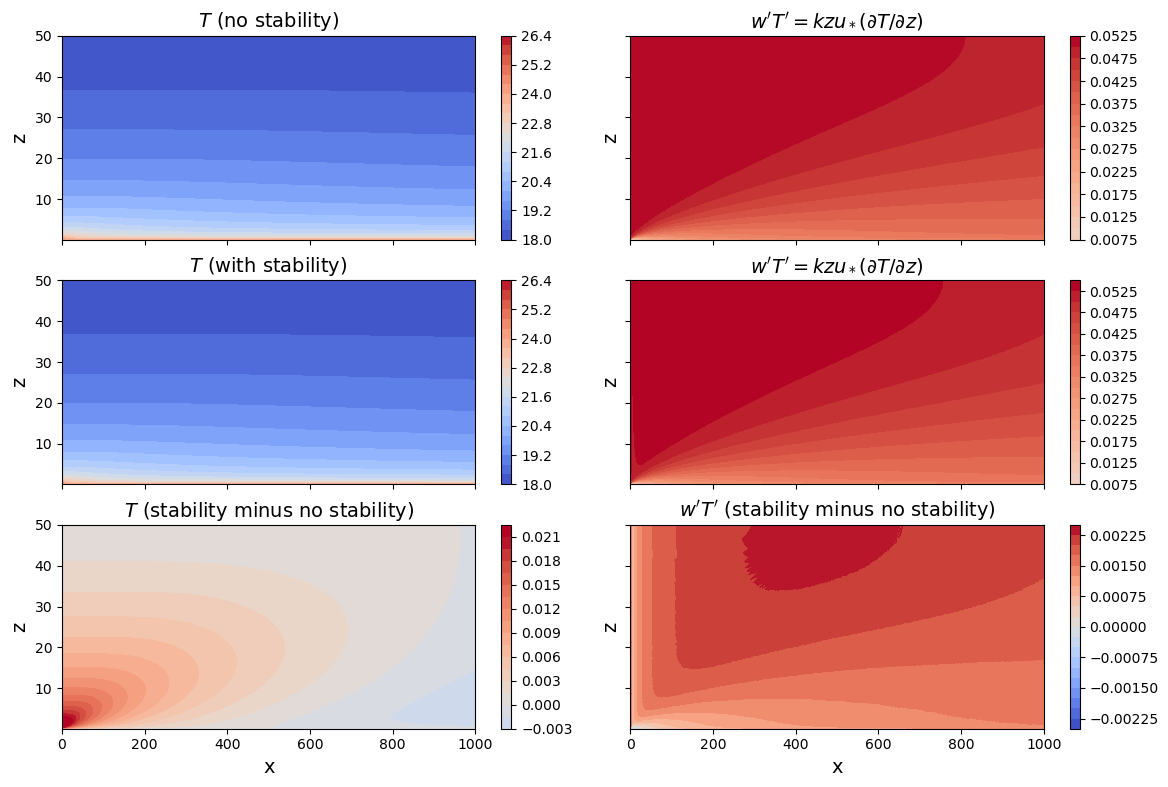

In [36]:
fig, axes = plt.subplots(3,2, figsize= (14, 9), sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.1)
axes = axes.ravel()

plot_colormap(no_stability, 'T', '$T$ (no stability)', axes[0])
plot_colormap(no_stability, 'FluxT', r"$w'T' = k z u_* ({\partial T}/{\partial z})$", axes[1], vmin = 'center')

plot_colormap(w_stability, 'T', '$T$ (with stability)', axes[2])
plot_colormap(w_stability, 'FluxT', r"$w'T' = k z u_* ({\partial T}/{\partial z})$", axes[3], vmin = 'center')

plot_colormap(difference, 'T', '$T$ (stability minus no stability)', axes[4], vmin = 'center')
plot_colormap(difference, 'FluxT', r"$w'T'$ (stability minus no stability)", axes[5], vmin = 'center')

for i, ax in enumerate(axes):
    if i < 4:
        ax.set_xlabel('')


Text(0.5, 1, 'With stability')

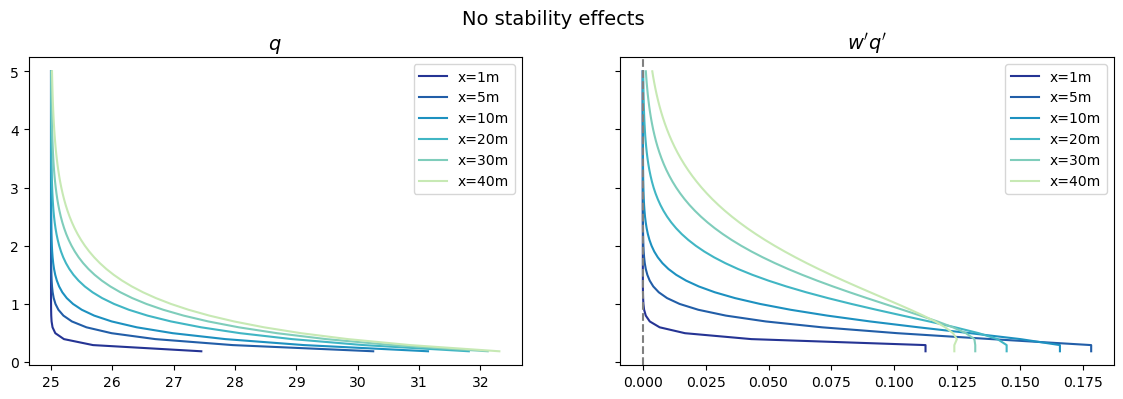

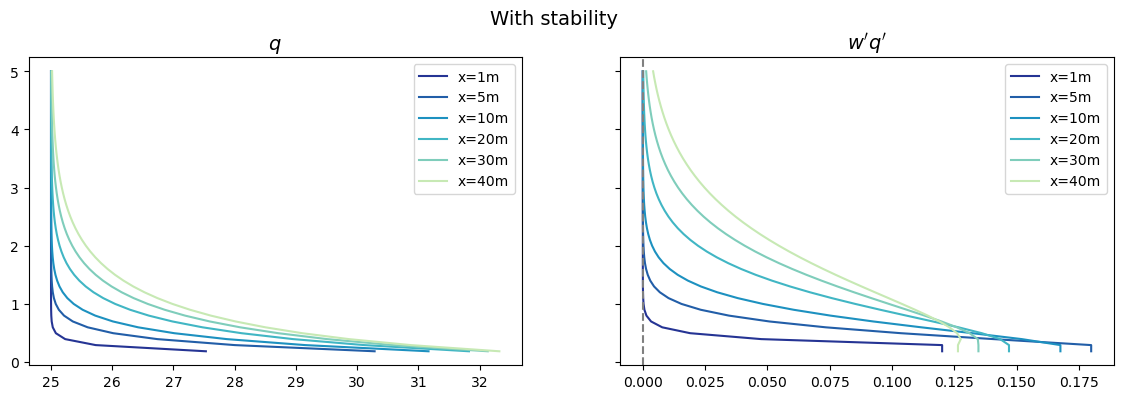

In [39]:
fig, axes = plt.subplots(1,2, figsize= (14, 4), sharey = True)
plot_profile(no_stability, 'Q', "$q$", axes[0], z_ind = 50, cmap = blues)  
plot_profile(no_stability, 'FluxQ', "$w'q'$", axes[1], z_ind = 50, cmap = blues)  
axes[1].axvline(0, c = 'grey', ls = '--')
plt.suptitle("No stability effects", y = 1, fontsize = 14)

fig, axes = plt.subplots(1,2, figsize= (14, 4), sharey = True)
plot_profile(w_stability, 'Q', "$q$", axes[0], z_ind = 50, cmap = blues)  
plot_profile(w_stability, 'FluxQ', "$w'q'$", axes[1], z_ind = 50, cmap = blues)  
axes[1].axvline(0, c = 'grey', ls = '--')
plt.suptitle("With stability", y = 1, fontsize = 14)


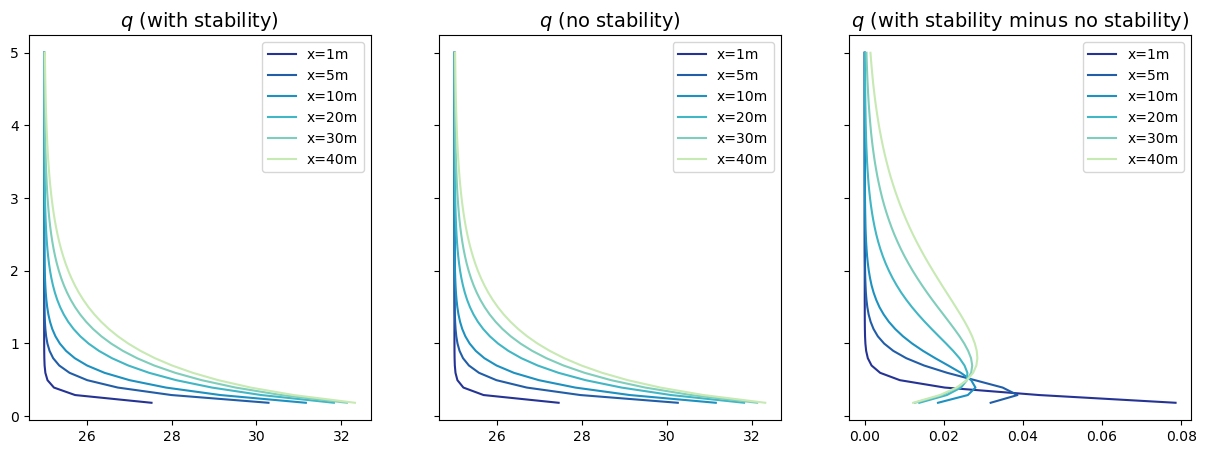

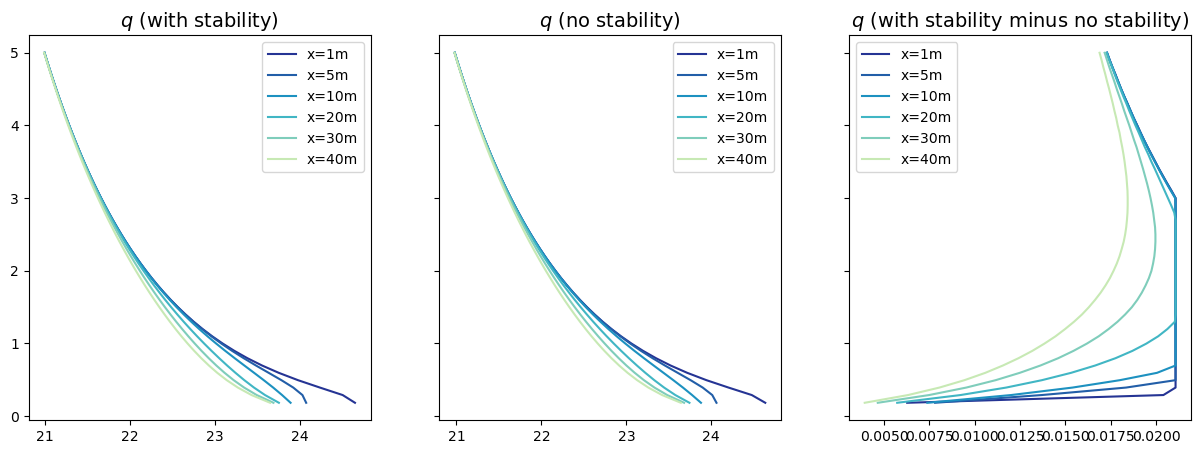

In [42]:
fig, axes = plt.subplots(1,3, figsize= (15, 5), sharey = True)
z_ind = 50
plot_profile(w_stability, 'Q', "$q$ (with stability)", axes[0], z_ind = z_ind, cmap = blues)  
plot_profile(no_stability, 'Q', "$q$ (no stability)", axes[1], z_ind = z_ind, cmap = blues)  
plot_profile(difference, 'Q', "$q$ (with stability minus no stability)", axes[2], z_ind = z_ind, cmap = blues)  

fig, axes = plt.subplots(1,3, figsize= (15, 5), sharey = True)
z_ind = 50
plot_profile(w_stability, 'T', "$q$ (with stability)", axes[0], z_ind = z_ind, cmap = blues)  
plot_profile(no_stability, 'T', "$q$ (no stability)", axes[1], z_ind = z_ind, cmap = blues)  
plot_profile(difference, 'T', "$q$ (with stability minus no stability)", axes[2], z_ind = z_ind, cmap = blues)  


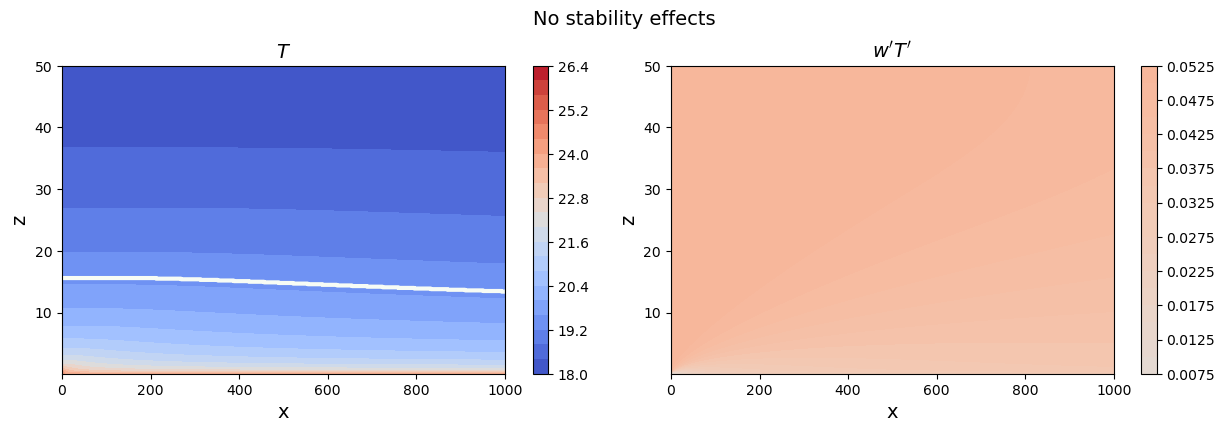

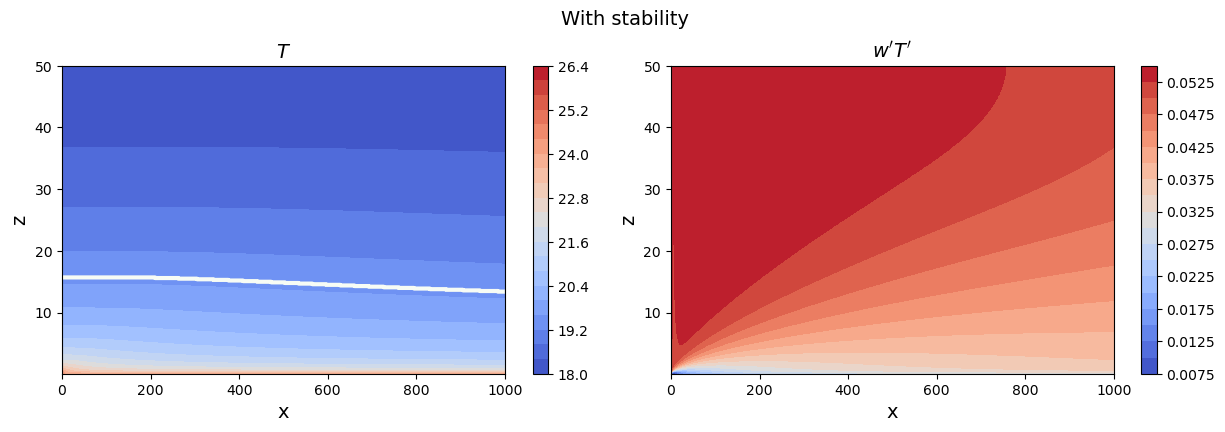

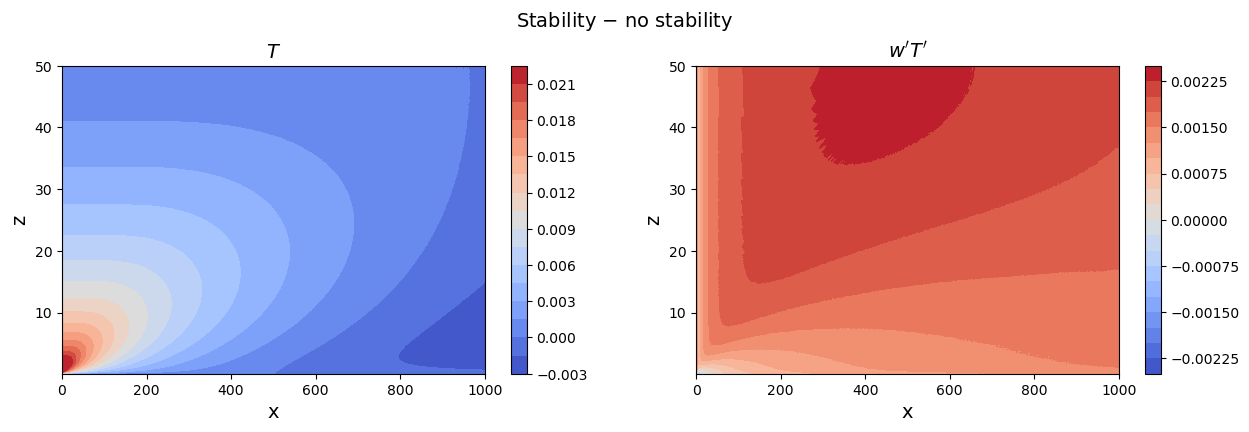

In [43]:

fig, axes = plt.subplots(1,2, figsize= (15, 4))
plt.suptitle("No stability effects", y = 1.02, fontsize = 14)
plt.subplots_adjust(wspace = 0.1)
plot_colormap(no_stability, 'T', '$T$', axes[0])
plot_colormap(no_stability, 'FluxT', "$w'T'$", axes[1], vmin = -0.15, vmax = 0.15)
axes[0].contour(no_stability['x'], no_stability['z'], no_stability['T'].T < 19.5, 0, 
                linewidths = 3, cmap = 'Greens')


fig, axes = plt.subplots(1,2, figsize= (15, 4))
plt.subplots_adjust(wspace = 0.1)
plt.suptitle("With stability", y = 1.02, fontsize = 14)
plot_colormap(w_stability, 'T', '$T$', axes[0])
plot_colormap(w_stability, 'FluxT', "$w'T'$", axes[1])#,  vmin = -1, vmax = 1)
axes[0].contour(w_stability['x'], w_stability['z'], w_stability['T'].T < 19.5, 0, 
                linewidths = 3, cmap = 'Greens')

fig, axes = plt.subplots(1,2, figsize= (15, 4))
plt.suptitle("Stability $-$ no stability", y = 1.02, fontsize = 14)
plot_colormap(difference, 'T', '$T$', axes[0])
plot_colormap(difference, 'FluxT', "$w'T'$", axes[1])#, vmin = -0.5, vmax = 0.5)

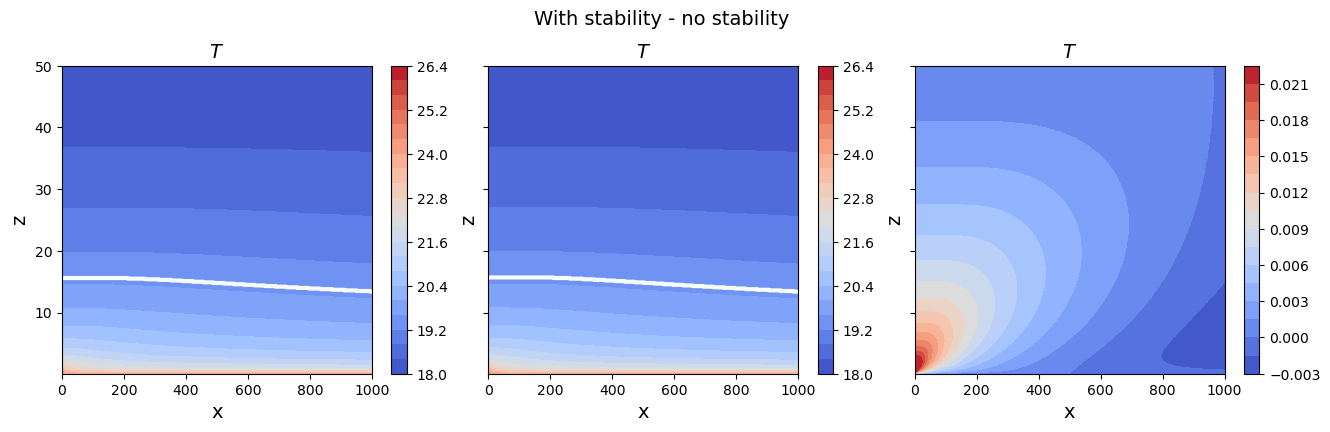

In [44]:
fig, axes = plt.subplots(1,3, figsize= (16, 4), sharey = True)
plt.suptitle("No stability effects", y = 1.02, fontsize = 14)
plt.subplots_adjust(wspace = 0.1)
plot_colormap(no_stability, 'T', '$T$', axes[0])
axes[0].contour(no_stability['x'], no_stability['z'], no_stability['T'].T < 19.5, 0, 
                linewidths = 3, cmap = 'Greens')


plt.subplots_adjust(wspace = 0.1)
plt.suptitle("With stability", y = 1.02, fontsize = 14)
plot_colormap(w_stability, 'T', '$T$', axes[1])
axes[1].contour(w_stability['x'], w_stability['z'], w_stability['T'].T < 19.5, 0, 
                linewidths = 3, cmap = 'Greens')


plt.suptitle("With stability - no stability", y = 1.02, fontsize = 14)
plot_colormap(difference, 'T', '$T$', axes[2])


In [45]:
# quantify height of BL where q 
threshold_q = no_stability['Qs'] + 0.8*(no_stability['Qa'] - no_stability['Qs'])
threshold_T = no_stability['Ts_u'] - 0.8*(no_stability['Ts_u'] - no_stability['Ts_d'])

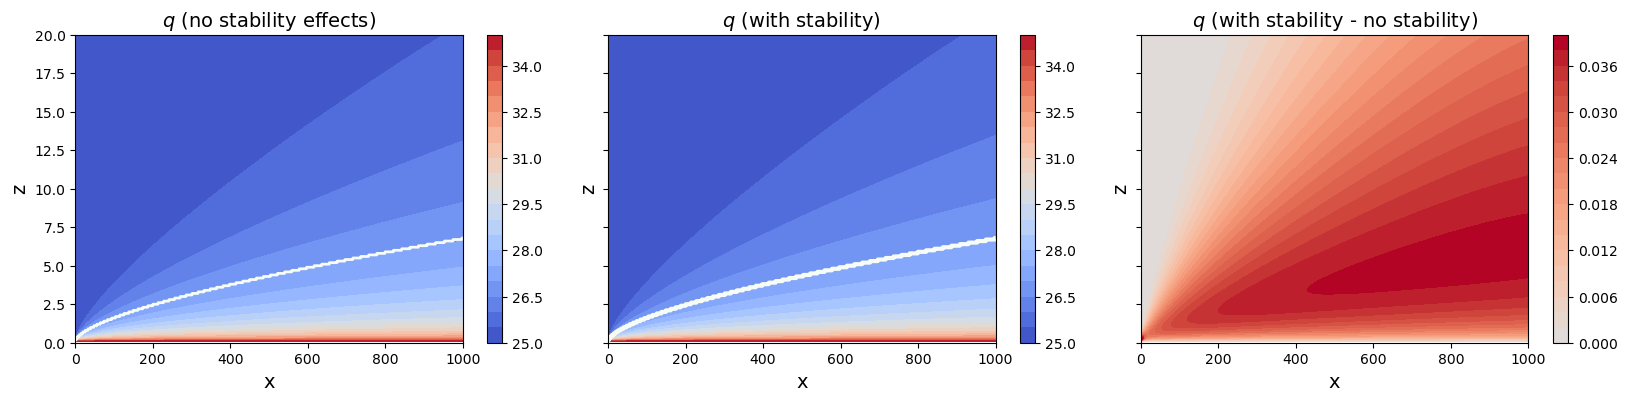

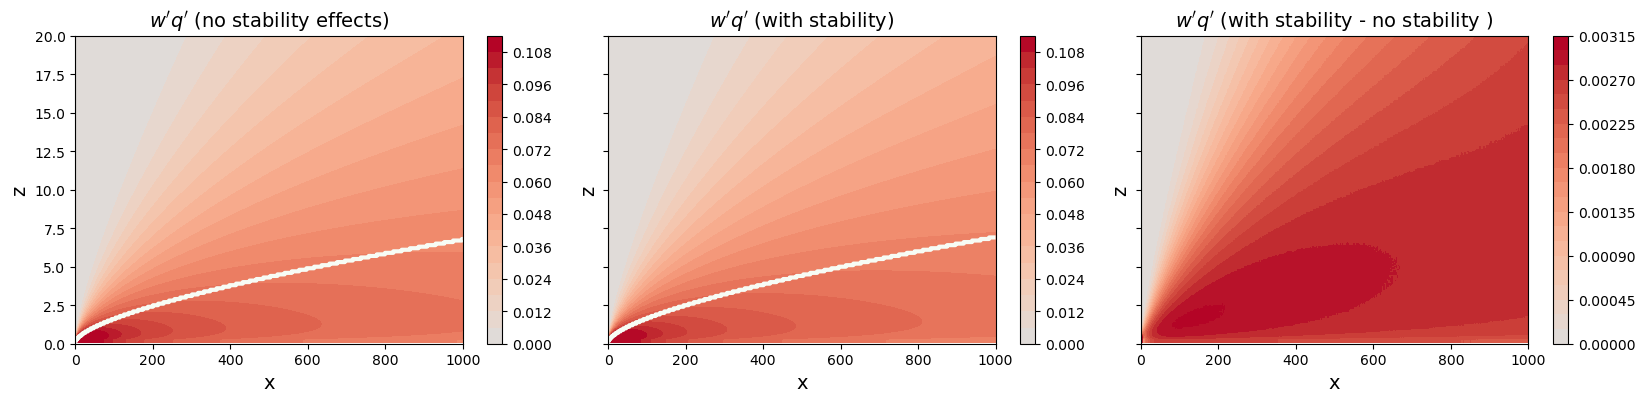

In [46]:
fig, axes = plt.subplots(1,3, figsize= (20, 4), sharex = True, sharey = True)

plt.subplots_adjust(wspace = 0.1)

plot_colormap(no_stability, 'Q', '$q$ (no stability effects)', axes[0])
axes[0].contour(no_stability['x'], no_stability['z'], no_stability['Q'].T < threshold_q, 0, 
                linewidths = 2, cmap = 'Greens')


plot_colormap(w_stability, 'Q', '$q$ (with stability)', axes[1])
axes[1].contour(no_stability['x'], no_stability['z'], no_stability['Q'].T < threshold_q, 0, 
                linewidths = 3, cmap = 'Greens')

plot_colormap(difference, 'Q', '$q$ (with stability - no stability)', axes[2], 
              vmin = "center", cmap = 'coolwarm')

axes[0].set_ylim(0, 20)



fig, axes = plt.subplots(1,3, figsize= (20, 4), sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0.1)

plot_colormap(no_stability, 'FluxQ', "$w'q'$ (no stability effects)", axes[0], vmin = "center")
axes[0].contour(no_stability['x'], no_stability['z'], no_stability['Q'].T < threshold_q, 0, 
                linewidths = 3, cmap = 'Greens')

plot_colormap(w_stability, 'FluxQ', "$w'q'$ (with stability)", axes[1], vmin = "center")

axes[1].contour(w_stability['x'], w_stability['z'], w_stability['Q'].T < threshold_q, 0,  
                linewidths = 3, cmap = 'Greens')
axes[0].set_ylim(0, 20)

plot_colormap(difference, 'FluxQ', "$w'q'$ (with stability - no stability )", 
              axes[2], vmin = "center", cmap = 'coolwarm')

# moisture flux is smaller when stability effects are included

In [47]:
z_q = np.ones_like(params['x'])
for i in range(params['nx']+1):
    z = params['z']
    ind = np.where(no_stability['Q'][i] < threshold_q)[0][0]
    z_q[i] = z[ind]
    
    
z_q_stability = np.ones_like(params['x'])
for i in range(params['nx']+1):
    z = params['z']
    ind = np.where(w_stability['Q'][i] < threshold_q)[0][0]
    z_q_stability [i] = z[ind]    

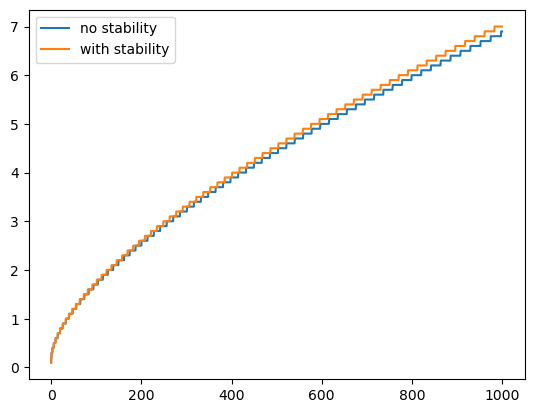

In [48]:
plt.plot(x, z_q, label = 'no stability')
plt.plot(x, z_q_stability, label = "with stability")
plt.legend()

Text(0.5, 0, '$x$')

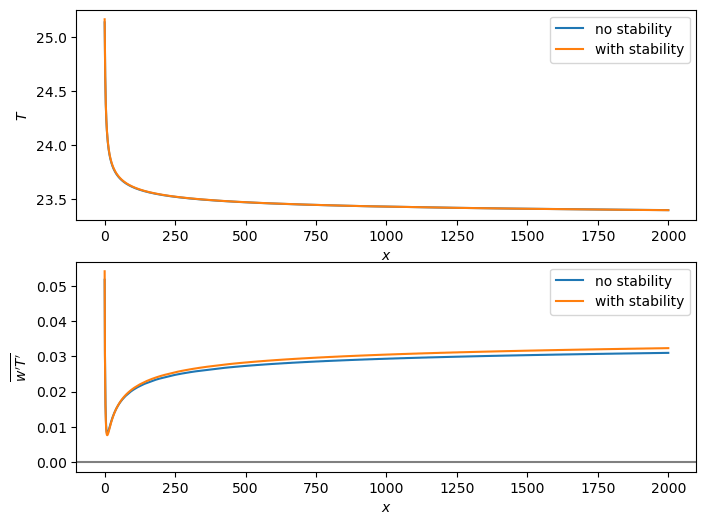

In [49]:
fig, axes = plt.subplots(2,1, figsize= (8, 6))

ax = axes[0]
ax.plot(no_stability['T'][:, 1], label = "no stability")
ax.plot(w_stability['T'][:, 1], '-', label = "with stability")
ax.legend()
ax.set_ylabel(r"$T$")
ax.set_xlabel(r"$x$")

ax = axes[1]
ax.plot(no_stability['FluxT'][:, 0], label = "no stability")
ax.plot(w_stability['FluxT'][:, 0], '-', label = "with stability")
ax.axhline(0, c= 'grey')
ax.legend()
ax.set_ylabel(r"$\overline{w'T'}$")
ax.set_xlabel(r"$x$")
# ax.set_ylim(-0.05, 0.05)


In [50]:
no_stability['FluxTotal'] = no_stability['FluxT']*1005*1.2 + no_stability['FluxQ']*2.5*1e6/1000

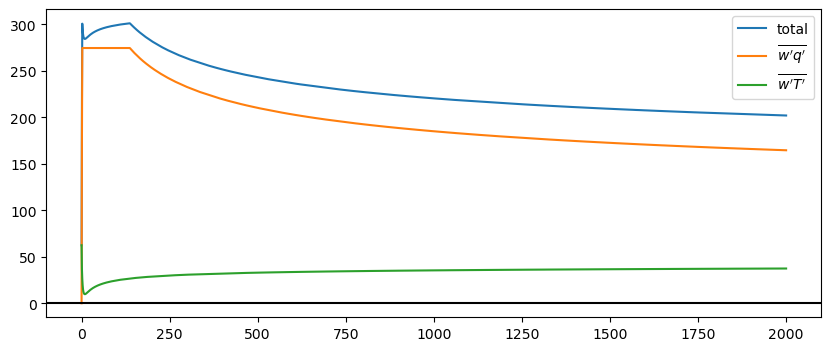

In [54]:
plt.figure(figsize = (10,4))
ax = plt.gca()
level = 0
ax.plot(no_stability['FluxTotal'][:, level], label = 'total')
ax.plot(no_stability['FluxQ'][:, level]*2.5*1e6/1000, label = "$\overline{w'q'}$")
ax.plot(no_stability['FluxT'][:, level]*1005*1.2, label = "$\overline{w'T'}$")
ax.legend()
ax.axhline(0, c= 'k')



3.0

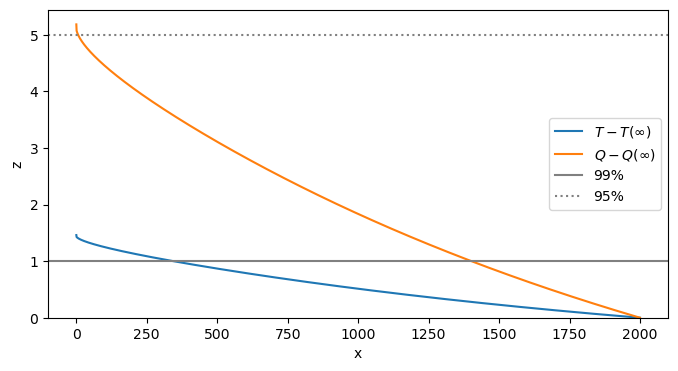

In [55]:
fig, axes = plt.subplots(1, sharey = True, figsize = (8, 4))
ax = axes

zind = np.where(params['z'] > 30)[0][0]
ref = w_stability['T'][-1][:zind]
ax.plot((((w_stability['T'][:, :zind] - ref)/ref).T).mean(0)*100, label = '$T - T(\infty)$')
ref = w_stability['Q'][-1][:zind]
ax.plot((((- w_stability['Q'][:, :zind] + ref)/ref).T).mean(0)*100, label = '$Q - Q(\infty)$')

ax.axhline(1, c = 'grey', label = "99%")
ax.axhline(5, c = 'grey', ls = ':', label = "95%")
ax.set_ylim(0)
ax.legend()
ax.set_ylabel("z")
ax.set_xlabel("x")

ind = np.where((((- w_stability['Q'][:, :zind] + ref)/ref).T).mean(0)*100  > 5)[0][-1]
params['x'][ind]   


$$u \frac{\partial u}{\partial x} = - \frac{\partial}{\partial z} \overline{w'u'}$$

$$ \overline{w'u'} = - k_t \frac{\partial \overline u}{\partial z} $$

$$K_t = kz u^*$$

- Momentum adjustment is fast

$$u \frac{\partial T}{\partial x} = - \frac{\partial}{\partial z} \overline{w'T'}$$

$$ \overline{w'T'} = - T_t \frac{\partial \overline T}{\partial z} $$

$$K_t = k z u^*$$

$$ T_a - T_s = - \frac{ \overline{w'T'}}{k u_\star} \ln \bigg(\frac{z}{z_{oh}}\bigg) $$

$$  z_{oh} \approx 0.1 z_{om} $$

$$ q(z_{oh}) = e^{\star} (T_s)$$   
$z_{oh}$:  heat roughness heigh
$e^{\star} (T_s)$ : saturation vapor pressure


$$ - K_t \frac{\partial T}{\partial z} = - k z u_\star \frac{\partial T}{\partial z}  = const$$

$$ - k  u_\star d T = \frac{dz}{z} C $$


$$ d T = - \frac{dz}{z } \frac{C}{ k  u_\star }  $$

$$ K_t = \frac{- \overline{u'w'}}{\partial \overline u/ \partial z}= \  \text{flux of momentum} / \frac{\partial \overline u}{ \partial z} $$

$$ u_\star = (- \overline{u'w'})^{1/2} = \sqrt{\tau / \rho}$$

$$ \frac{\partial \overline u}{\partial z} = \frac{u_\star}{kz}$$

$$ \overline {u'w'} = - u_\star^2$$

$$ K_t = \frac{u_\star^2}{u_\star / kz} = u_\star ( kz )= \text{velocity}\times \text{length} $$ 

Upwind BCs

$$ T_a - T_s = - \frac{\overline{w'T'}}{k u_\star} ln (z / z_{oh}) $$


$ z_{om} = 0.1$ m, $ z_{oh} = 0.1 z_{om}$ m, $u_\star = 0.25 $ m/s

$$ 18 - 30 = - \frac{\overline{w'T'}}{k u_\star} \ln (200 /0.1^2) $$

$$  - \overline{w'T'} = (18 - 30 ) {k u_\star} / \ln (200 /0.1^2) $$

$\overline{w'T'}  $ -  Known from upwind boundwary condition and log law

Upwind profile prescribed



In [595]:
wT = (18 - 30 )*(0.4* 0.25 ) / np.log(200 /0.1**2) 

## Stability  


$ L$ = buoyancy vs mechanical shearing 

$$ L = u_\star^3 / k g \overline{w'T'} /T_a$$  

$T_a$ in Kelvin

$\chi = - x/L$

$$ \overline u = \frac{u_\star }{k} \big[ \ln (z/z_o) - \psi_m (z/z_o) \big]$$

$$ \overline u \frac{\partial \overline T }{\partial x} = - \frac{\partial}{\partial z } \overline {w'T'} $$

$$ \overline{w'T'} = - \frac{k z u_\star}{\phi_h (z/L)} \frac{\partial \overline T }{\partial z}  $$





$$ \overline u \frac{\partial \overline q }{\partial x} = - \frac{\partial}{\partial z } \overline {w'q'} $$

$$ \overline{w'q'} = - \frac{k z u_\star}{\phi_v (z/L)} \frac{\partial \overline q }{\partial z}  $$


Wall bounded flow : $\alpha T \sigma_w^2 = k z u_\star$

